<div style="text-align: right"> Germanna, 
<b>Chapter 2: Introduction to Machine Learning for Anomaly Detection</b> </div>


<div style="text-align: right">Lab: Anomaly Detection</div>



Part 1: [Prepare](#part1)<br>
1. [Histograms](#histograms)<br>
2. [Outliers](#univ_stdev)<br>
3. [Anomaly Detection](#anomalous)<br>

Part 2: [Assignment](#Assignment)<br>
1. [Introduction to Phishing URL Detection](#Assignment)<br>
2. [EDA](#eda)<br>
3. Model-Building <br>
3.1 [Decision Tree Classifier](#dectree)<br>
3.2 [Logistic Regression](#logreg)<br>
4. Model Performance & Comparison <br>
4.1.1 [Confusion Matrix (Decision Tree)](#confmat_dectree)<br>
4.1.2 [Confusion Matrix (Logistic Regression)](#confmat_logreg)<br>
4.2.1 [Evaluation Criteria(Decision Tree)](#eval_metrics)<br>
4.2.2 [Evaluation Criteria (Logistic Regression)](#eval_logreg)<br>
4.3 [Model Comparison](#modcompare)<br>

See also:
[Testing and Training Data](#testtrain)<br>


# Challenges of securing information

<a id="part1_background"></a>

When information is converted from paper to bits and stored on digital media, whether local or cloud-based, new methods of accessing that information are introduced. Guarding that information entails watching out for anomalies and guarding against anomalous access to the information.

Securing information is tantamount to detecting and stopping unauthorized intrusions. It is assumed that the nature of the intrusion is unknown, but that the intrusion will result in behavior different from that ***normally*** seen in the system. 
Most work on anomaly intrusion detection has determined profiles for user behavior. Intrusions are detected when a user behaves out of character. These anomalies are detected by using statistical profiles. This requires an introduction to statistical tools, the most important of which is the **histogram**.

<div style="text-align: right">Part 1</div>
<a id="part1"></a>

# An introduction to Histograms

<a id="histograms"></a>

A [histogram](https://en.wikipedia.org/wiki/Histogram) is a representation of the **distribution** of numerical data. It is an estimate of the probability distribution of a continuous variable and was first introduced by [Karl Pearson](https://en.wikipedia.org/wiki/Karl_Pearson). It differs from a bar graph in the sense that a bar graph relates two variables but a histogram ***relates only one***.

Histograms are incredibly useful because they allow us to build a **model** of our empirical data. Once we build a model, that model is valid for any other data that follows the same statistics as our original dataset. So, using the model, we will be able to predict whether a new datapoint is **like** the original data. If our original data consists of benign URLs, then after we build the histogram of benign URLs, we wil be able to predict whether a new URL belongs to the original data (and is thus benign), or whether it is **anomalous** (and thus malicious). We call this approach the analytic approach to anomaly detection.

We can also use Machine Learning (ML) algorithms to build models that are capable of telling us whether a new data point tracks original dataset statistics. We call this approach the ML approach to anomaly detection.

To construct a histogram, the first step is to "bin" (or "bucket") the range of $y$ values—that is, divide the entire range of $y$ values of your dataset into a series of intervals and then count how many values fall into each interval. 

The vertical axis of a histogram shows the frequency, while the horizontal axis usually has bins. Every bin has a minimum and maximum value, and they are usually ordered in monotonically increasing values of $y$.

Histograms give a rough sense of the density of the underlying distribution of the data. Histograms ***look*** like **2D plots**, with an x-axis and a y-axis, but in fact only the y-axis values count. The x-axis consists of bins in which we group all similar y-values. We want to know how many times we see the same y-value in the distrubution of our data, and that is what the histogram does. So a histogram is really a **1D plot**.

Histograms are the easiest way to distinguish between two datasets, for example between authorized access attempts to information and unauthorized ones.

In [1]:
import numpy as np
import pandas as pd

# Sample from two different normal distributions
means = 10, 20
stdevs = 4, 2
dist = pd.DataFrame(
    np.random.normal(loc=means, scale=stdevs, size=(1000, 2)),
    columns=['a', 'b'])
dist.agg(['min', 'max', 'mean', 'std']).round(decimals=2)

,a,b
min,-3.50,14.29
max,23.69,26.09
mean,10.03,20.06
std,4.05,2.00


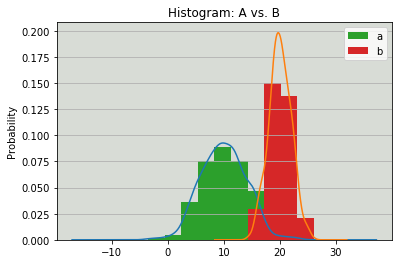

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') 

fig, ax = plt.subplots()
dist.plot.kde(ax=ax, legend=False, title='Histogram: A vs. B')
dist.plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

## A pinch of statistics

It's great that using histograms we can see the difference between two distributions. But we're relying on eyeballs. Can we automate this process so we don't have to rely on analysts looking at histograms?

### Detection of anomalies

<a id="anomaly_detection"></a>

Detection of anomalies like malicious web sites is enabled by **probabilistic models** of your data. That means you can actually see what the probability of observing every possible event might be under your model. 

When you observe an event that has sufficiently low probability, as with a malicious URL, you label it as **anomalous**.

Let's start with data with a single, [normally distributed](https://en.wikipedia.org/wiki/Normal_distribution) feature. In probability theory, the normal (or Gaussian) distribution is a very common distribution. That is because the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) states that averages of samples of observations of random variables ***independently drawn*** from the same distribution converge in distribution to the Gaussian. That is, they become normally distributed when the number of observations is sufficiently large.

If  you need any convincing that a random process, after a sufficiently large set of observations, yields a near-Gaussian histogram, look no further than [here](https://www.mathsisfun.com/data/quincunx.html).

Let's generate 1000 such **normal** observations. We will use numpy's `random.normal` API, which generates apparently random numbers, which yet are distributed according to a gaussian histogram. The top figure are the numbers themselves, the lower figure their histogram (how many of these numbers we have observed). The histogram here is wicked revealing, since we can't see how many points of a certain value we have generated in the top plot, since they overlay each other, unless we look at the corresponding bin in the histogram below.

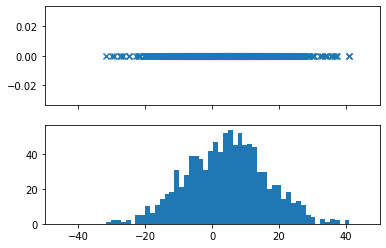

In [3]:
N = 1000
X1 = np.random.normal(4, 12, N)

f, axes = plt.subplots(nrows=2, sharex=True)
axes[0].set_xlim(-50, 50)
axes[0].scatter(X1, np.zeros(N), marker='x')
axes[1].hist(X1, bins=50)
plt.show()

Let's take the mean and the standard deviation from the sample.


In [4]:
sample_mean = X1.mean()
sample_sigma = X1.std()
print('Sample Mean:', sample_mean)
print('Sample Standard Deviation:', sample_sigma)

Sample Mean: 4.351933597660852
Sample Standard Deviation: 11.898227946983482


If you looked at the Wikipedia reference for the Gaussian in the cell above, you know that all you need to reproduce the Gaussian histogram, ***analytically***, is the mean and the standard deviation of the data, which we evaluated above.

So our analytic estimate for the distribution therefore looks like this, using `scipy`'s `stats.norm.pdf` API:

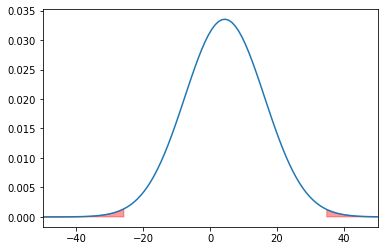

Lower Bound: -25.393636269797852
Upper Bound: 34.09750346511956


In [5]:
import scipy as sp
base = np.linspace(-50, 50, 100)
normal = sp.stats.norm.pdf(base, sample_mean, sample_sigma)
lower_bound = sample_mean - (2.5 * sample_sigma)
upper_bound = sample_mean + (2.5 * sample_sigma)
anomalous = np.logical_or(base < [lower_bound]*100, base > [upper_bound]*100)

plt.plot(base, normal)
plt.fill_between(base, normal, where=anomalous, color=[1, 0, 0, 0.4])
plt.xlim(-50, 50)
plt.show()
print('Lower Bound:', lower_bound)
print('Upper Bound:', upper_bound)

### Outliers

Looks quite like our empirical (from data) histogram.

<a id="univ_stdev"></a>

Here we've colored lower and upper bounds in red, which are two and a half times the standard deviation of the data away from the mean, to show where we expect data [outliers](https://en.wikipedia.org/wiki/Outlier) to live. This is a rule of thumb for normal distributions: if you are two and a half times the standard deviation away from the mean, ***you are an outlier***!

If we didn't know about outliers, we'd have to decide on some 'epsilon' value, which dictates our probability threshold for anomalous events. For example, we could set epsilon to .01, saying that any draw for which there's a probability of 1% or less that it given the above distribution should be marked as anomalous. 

Let's look at two sample draws, red and green (hint hint), and decide if they're anomalous, using our defnition of outliers.

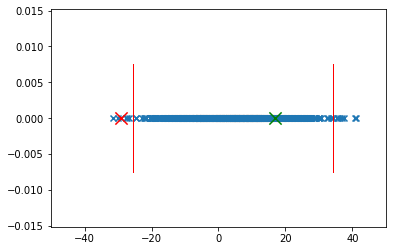

In [6]:
plt.scatter(X1, np.zeros(N), marker='x')
plt.xlim(-50, 50)
plt.scatter(-29, 0, marker='x', color='red', s=150, linewidths=3)
plt.scatter(17, 0, marker='x', color='green', s=150, linewidths=3)
plt.axvline(lower_bound, ymin=.25, ymax=.75, color='red', linewidth=1)
plt.axvline(upper_bound, ymin=.25, ymax=.75, color='red', linewidth=1)
plt.show()

### Categorizing data as anomalous

<a id="anomalous"></a>

We see that the red draw exceeds the lower bound, and would therefore be categorized as **anomalous**. In contrast. the green draw falls within the normal range.

Note that we’re losing some uncertainty by doing it this way. We’re using the **sample mean** and **sample standard deviation** directly as estimates for the population mean and standard deviation, but of course there is some uncertainty in those estimates. This model has no mechanism for preserving that uncertainty; we get the same probability estimate for any given event regardless of how certain we are about our estimates for those parameters. In our notebook on **Bayesian analysis**, we will fix this!


### Independently Distributed Multivariate data

<a id="multivariate"></a>

So far we've only been looking at observations with a single feature. We call these **univariate**.

If we look at multiple variables, we'll need to consider **mutli-variate data**. 

Initially we will assume that they are **independently normal distributed**. That is, each feature is normally distributed on its own, and there is no correlation between them (such as in the plot below). Keep in mind that realistic data is seldom univariate. 

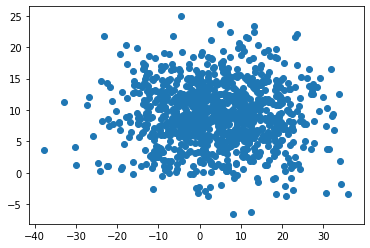

In [7]:
N = 1000
X1 = np.random.normal(4, 12, N)
X2 = np.random.normal(9, 5, N)
plt.scatter(X1, X2)
plt.show()

### Correlated Multivariate data

<a id="cor_multi"></a>


Consider if our two datasets (x1 and x2) are **correlated**, for example the way domain names and URL lengths are correlated, for both benign and malicious URLs.

Let's build a 2D dataset where the two random variables are correlated and plot it using seaborn's jointplot:

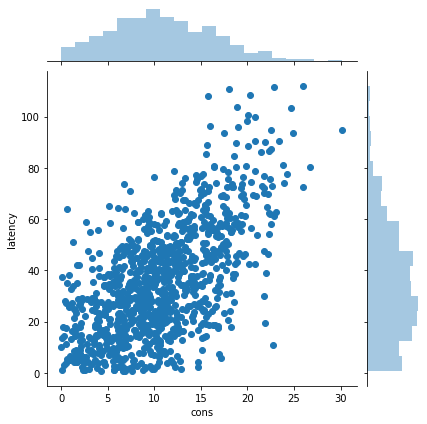

In [8]:
import seaborn as sns

def positive_support_normal(mean, sigma, n):
    xs = np.random.normal(mean, sigma, n)
    for i, num in enumerate(xs):
        while num < 0:
            num = np.random.normal(mean[i], sigma)
        xs[i] = num
    return xs
    
N = 1000

mu_cons = 10
sigma_cons = 6
sigma_latency = 20
beta = 3

cons = positive_support_normal(np.array([mu_cons]*N), sigma_cons, N)
latency = positive_support_normal(beta * cons, sigma_latency, N)
ax = sns.jointplot('cons', 'latency', pd.DataFrame({'cons': cons, 'latency': latency}))


To learn more about looking for outliers when dealing with multivariate data, check out **[PyOD](https://github.com/yzhao062/pyod)**, which is a comprehensive **Python toolkit for outlier detection** in 
multivariate data with both unsupervised and supervised approaches. 

<div style="text-align: right">Part 2</div>

# Assignment: Phishing URL Detection

<a id="Assignment"></a>


In this section, we will apply some of the previous concepts along with machine learning models to attempt to predict whether a URL is _phishing_ or legitimate. Before we do so, let's understand what constitutes _phishing_.

From Wikipedia, https://en.wikipedia.org/wiki/Phishing :

> Phishing is the fraudulent attempt to obtain sensitive information such as usernames, passwords and credit card details, often for malicious reasons, by disguising as a trustworthy entity in an electronic communication. The word is a neologism created as a homophone of fishing due to the similarity of using a bait in an attempt to catch a victim. The annual worldwide impact of phishing could be as high as US$5 billion.
>
> Phishing is typically carried out by email spoofing or instant messaging, and it often directs users to enter personal information at a fake website, the look and feel of which are identical to the legitimate site, the only difference being the URL of the website in concern. Communications purporting to be from social web sites, auction sites, banks, online payment processors or IT administrators are often used to lure victims. Phishing emails may contain links to websites that distribute malware.
>
> Phishing is an example of social engineering techniques used to deceive users, and it exploits weaknesses in current web security. Attempts to deal with the growing number of reported phishing incidents include legislation, user training, public awareness, and technical security measures.

Here's an example of a real phishing email sent in 2011 by attackers looking to get login credentials for Facebook users:

<pre>
LAST WARNING : Your account is reported to have violated the policies that are considered annoying or insulting Facebook users.

Until we system will disable your account within 24 hours if you do not do the reconfirmation.

Please confirm your account below:

[ Link Removed ]

Thanks.
The Facebook Team
Copyright facebook © 2011 Inc. All rights reserved.
</pre>

A victim clicking on the Phishing link would be taken to a site that looked like a pretty good copy of the Facebook login screen.

<img src="Not_Facebook.png">

Here are some examples of the links used in emails sent by the attackers running this phishing campaign:

**Note**: These links may be dangerous to your computer. Our practice will be to "neuter" links by wrapping certain characters with square brackets so that you cannot click on these links, or accidentally copy/paste them into your browser.

**CAUTION: DO NOT CLICK ON OR VISIT THESE LINKS!!**
<pre>
http[:]//team-welcome[.]at[.]ua/facebook-support[.]html
http[:]//reportedpages[.]at[.]ua/facebook-support-account[.]html
http[:]//www[.]facebooks[.]cloud/PayPlls[.]CEanada[.]tNZnZZlR3ZdyZZ-5RkZZDRTZZBy
http[:]//www[.]greenaura[.]net/appz[.]westpac/westpac[.]appz/login[.]php
http[:]//www[.]irastrum[.]com/wp-admin/mail[.]yahoo[.]com/
http[:]//appleid[.]apple[.]com-subscriptions[.]manager508158125[.]kevinfoley[.]com
</pre>
**CAUTION: DO NOT CLICK ON OR VISIT THESE LINKS!!**


Something smells a little phishy about these links. Given a close look by a human, you'd probably be able to decide pretty quickly if the link was really sent by Facebook or not. But billions of people get hundreds or thousands of emails each every day! How can defenders keep up with the onslaught by the phishers?

## The Problem

We want to use methods from Machine Learning to build a computer program that will automatically flag links it thinks are phishing attempts. We can do this by studying the problem, looking at data, and learning a decision rule.

Analyze the data, build a model, and report your findings.

What else do you think you should do about the problem?

## Characteristics of Phishing Domains

Each web page has an address called a Uniform Resource Locator (URLs). A typical URL can be broken down into parts.

<img src="URL_Breakdown.png">

## Features Used for Phishing Domain Detection

Malicious phishing URLs and their web pages often have several tell tale features which can be used to tell them apart from benign legitimate URLs. For example, an attacker can register long and confusing domain to hide the actual domain name, maybe including subtle typos in the names of the target (ex. Faceboook[.]com) In some cases attackers can use direct IP addresses instead of using the domain name.

Our hypothesis is that if we can come up with enough distinguishing features of URLs we can teach our computer program to tell phishing URLs apart from legitimate URLs. Some of the common places to study these features for a phishing campaign are:

1. URLs
2. Domain information
3. Message and Webpage content

Let's take a look at some examples of the first two:

#### URL-Based Features

URLs of phishing domains often have distinctive features. Some things that stand out from reviewing phishing URLs are:

* \# of Digits in the URL. Phishing URLs often have lots of numbers in them compared to legitimate URLs.
* Length of the URL. Phishing URLs are often longer and more complicated than legitimate URLs.
* Number of subdomains in URL. Phishing URLs often attempt to obscure the real domain the user is being sent to by using lots of subdomains (ex. icloud.apple.com-thisisactuallythedomainoverhere[.]tk)
* Is Top Level Domain (TLD) one of the commonly used one like .com or .org, or is it one that is run by a company that doesn't do a lot of checking on what its customers are up to (*cough* .ru *cough*)?
* Checking whether it includes a legitimate brand name or not (apple-icloud-login[.]com)
* Checking whether the URL is Typosquatted or not. (ex. google.com vs goggle[.]com)

URL based features are a great place to start. But there's more information available you could leverage.


#### Domain-Based Features

An attacker has to use a domain name to host his webpage. What sort of things can that domain name tell us?

* Does the IP address associated with this domain appear on security blacklists? Often attackers will reuse their computer infrastructure to carry out different attacks (cheap? lazy? both?). Did we already catch them under an old name?
* How long ago was the domain registered (created)? Newly created domain names aren't usually associated with big brands like your bank or Facebook, so why is a brand new piece of the web asking for my social security number?
* Is the registrant's name hidden in the WHOIS (directory) information? Legitimate businesses aren't usually interested in obscuring the address of their IT dept. from the Internet's white pages.
* Rank on the Majestic Million Sites list. Security researchers use lists like these to see if a site is broadly popular. Sites that are visited by lots of people tend to be legit, while phony sites tend to be visited by the small number of victims that are tricked into visiting them.


These are just some ideas that people have found useful for identifying Phishing attacks. They're not foolproof, and attackers are evolving all the time as we get better at stopping them. 

## Explore the Data

<a id="eda"></a>

Let's take a look at some of these features on a set of URLs from PhishTank and DMOZ. Data scientists call this process of better understanding the data _Exploratory Data Analysis (or EDA)_.

* Benign or Malicious
* URL
* Length of URL
* Number of dots in URL
* Security sensitive words in URL?
* IP address present in URL?
* Domain creation (months)
* Domain expiration (months)
* Domain update (days)
* Registration zipcode
* Domain length
* Number of hyphens in domain
* Domain token count
* Largest domain tok length
* Average domain token length
* Suspicious TLD
* Directory portion length
* Number of subdirectories
* Path token count
* Largest path token length
* Average path token length
* Length of file
* Total dots in file
* Total delims in file
* Length of argument
* Number of variables
* Length of largest variable value
* Max number of argument delimiters

In [9]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import graphviz 

%matplotlib inline

In [10]:
###Opening Training Training Dataset file to read values
df = pd.read_csv('URL_Data.csv', index_col=0)

#### Printing the information of the Dataframe
df.head()

,len of url,no of dots,security sensitive words,no of hyphens in dom,dir_len,no of subdir,domain len,domain token count,path token count,ip present,...,len_of_argument,no_of_variables,len_of_largest_variable_val,max_no_of_argum_delims,create_age(months),expiry_age(months),update_age(days),zipcode,URL,Label
1,66,5,0,0,33,4,13,2,4,0,...,9,1,4,0,45,3,260,187553,http://taylortea.com/wp-content/plugins/akisme...,1
2,56,9,1,0,17,3,26,6,3,0,...,0,0,0,0,226,14,8,85016,http://hiroba.dqx.jp.isrel.usa.cc/account/app/...,1
3,19,1,0,0,1,0,18,2,0,0,...,0,0,0,0,-1,-1,-1,-1,http://resumeresources.ca/,0
5,50,7,1,2,1,0,46,5,0,0,...,0,0,0,0,-1,-1,-1,-1,http://notification-account.com.smk-diponegoro...,1
6,66,5,0,0,45,3,18,3,3,0,...,0,0,0,0,102,6,184,-1,http://www.roadrunners.pl/media/auth/df8207c6c...,1


Some descriptive statistics of the data

In [11]:
df.describe()

,len of url,no of dots,security sensitive words,no of hyphens in dom,dir_len,no of subdir,domain len,domain token count,path token count,ip present,...,total delims in file,len_of_argument,no_of_variables,len_of_largest_variable_val,max_no_of_argum_delims,create_age(months),expiry_age(months),update_age(days),zipcode,Label
count,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,...,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5.999000e+03,5999.000000
mean,38.169528,3.428405,0.109685,0.158026,10.668778,1.179197,19.766961,2.988998,1.179197,0.006168,...,0.084347,0.922154,0.060343,0.380230,0.015836,91.196533,12.435906,269.019837,6.298534e+06,0.530088
std,18.891208,1.899308,0.312523,0.511650,12.453855,1.453650,7.447003,0.818598,1.453650,0.078299,...,0.453088,4.669694,0.291641,2.559974,0.170075,92.883684,20.279709,608.936355,9.698731e+07,0.499135
min,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-78.000000,-115.000000,-1.000000e+00,0.000000
25%,21.000000,2.000000,0.000000,0.000000,1.000000,0.000000,15.000000,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,0.000000
50%,32.000000,3.000000,0.000000,0.000000,5.000000,1.000000,19.000000,3.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000,7.000000,87.000000,-1.000000e+00,1.000000
75%,58.000000,5.000000,0.000000,0.000000,17.000000,2.000000,23.000000,3.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,188.000000,12.000000,290.000000,5.100000e+01,1.000000
max,101.000000,13.000000,1.000000,9.000000,54.000000,8.000000,66.000000,11.000000,8.000000,1.000000,...,8.000000,50.000000,3.000000,35.000000,4.000000,365.000000,120.000000,9959.000000,4.913967e+09,1.000000


Let's visualize some of the columns of the dataset for the Phishing and Benign classes (Label), by plotting histograms of URL lengths, for the benign ones and the malicious ones. We use seaborn's `distplot` API to plot histograms, as well as the [kernel-density estimate](https://en.wikipedia.org/wiki/Kernel_density_estimation) that is essentially a smoothed out version of the histogram.

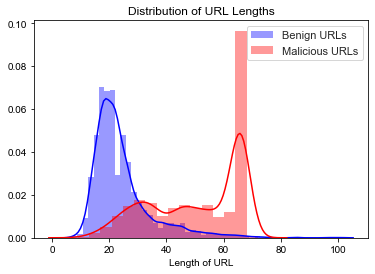

In [12]:
# Extract two columns of data from the overall dataset using a "selection mask"
url_length_benign    = df[df['Label']==0]['len of url']
url_length_malicious = df[df['Label']==1]['len of url']

# Use Seaborn to plot the histograms
sns.distplot(url_length_benign, color='blue', label='Benign URLs')
sns.distplot(url_length_malicious, color='red', label='Malicious URLs')

sns.set(style="whitegrid")
plt.legend(loc='upper right')
plt.rcParams['figure.figsize'] = [15, 5]

plt.title('Distribution of URL Lengths')
plt.xlabel('Length of URL')

plt.show()

Immediately, from the histograms, we see that the two datasets have different **densities**.

Our malicious URLs (red) tend to have longer URLs than our benign URLs (blue). And while the benign URLs on average tend to be around 20 characters, malicious URLs are much more spread out, which means they take on different lengths ***more often*** than bening URLS, which tend to have more similar lengths. We say that malicious URLs tend to have **dissimilar** lengths.

Let's take a look at the number of dots in a URLs and see if that can distinguish the classes. Again, we build histograms, but now the $y$ values pertain to the number of dots in the URL. We'll plot that histogram for the benign URLs, and then the malicious URLs.

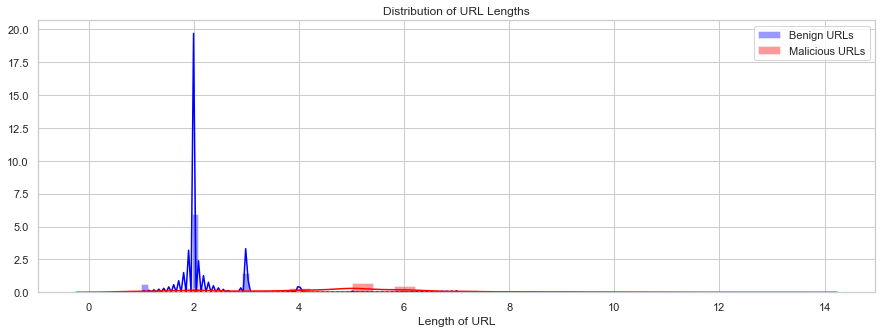

In [13]:
num_of_dots_benign    = df[df['Label']==0]['no of dots']
num_of_dots_malicious = df[df['Label']==1]['no of dots']

# Use Seaborn to plot the histograms
sns.distplot(num_of_dots_benign, color='blue', label='Benign URLs')
sns.distplot(num_of_dots_malicious, color='red', label='Malicious URLs')

sns.set(style="whitegrid")
plt.legend(loc='upper right')
plt.rcParams['figure.figsize'] = [15, 5]

plt.title('Distribution of URL Lengths')
plt.xlabel('Length of URL')

plt.show()

Immediately we see that there is a very strong concentration for benign URLs to have about 2 dots in them, and for about a fifth of them, 3 dots. On the other hand, malicious URLs have much more spread out possible values.

`Seaborn` is not the only package that yields histograms. We can also use `matplotlib` to do the same. Let's do this below, so you'll have multiple ways to build histograms.

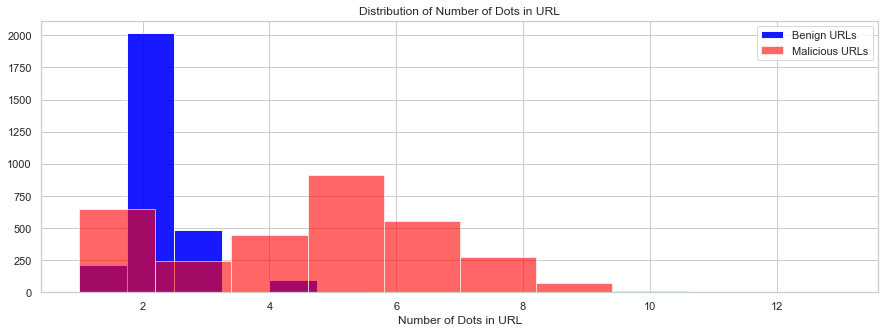

In [14]:
num_of_dots_benign    = df[df['Label']==0]['no of dots']
num_of_dots_malicious = df[df['Label']==1]['no of dots']

plt.hist(num_of_dots_benign, bins=8, alpha=0.9, label='Benign URLs', color='blue')
plt.hist(num_of_dots_malicious, bins=10, alpha=0.6, label='Malicious URLs', color='red')

plt.title('Distribution of Number of Dots in URL')
plt.xlabel('Number of Dots in URL')

sns.set(style="whitegrid")
plt.legend(loc='upper right')
plt.rcParams['figure.figsize'] = [15, 5]

plt.show()

We see malicious URLs tend to have more dots in them compared to benign URLs.

Next, let's take a look at domain name length. Let's plot histograms of domain name length for benign and malicious URLs.

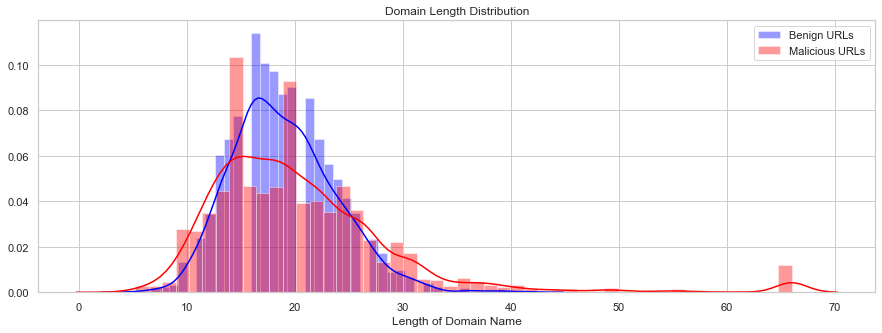

In [15]:
domain_len_benign    = df[df['Label']==0]['domain len']
domain_len_malicious = df[df['Label']==1]['domain len']

sns.distplot(domain_len_benign, color='blue', label='Benign URLs')
sns.distplot(domain_len_malicious, color='red', label='Malicious URLs')

plt.title('Domain Length Distribution')
plt.xlabel('Length of Domain Name')

sns.set(style="whitegrid")
plt.legend(loc='upper right')
plt.rcParams['figure.figsize'] = [15, 5]

plt.show()

Now the distributions look more similar, but thankfully the kernel density estimate curves (the smoothed out versions of the histogram) reveal that malicious URLs are still more spread out in values of domain name length.

And if we look at that lone outlier bin on the far right, we see that malicious domain names can sometimes be much much longer than benign domain names!

We can visualize how these two features (domain length and URL length) interact with each other with a scatterplot.

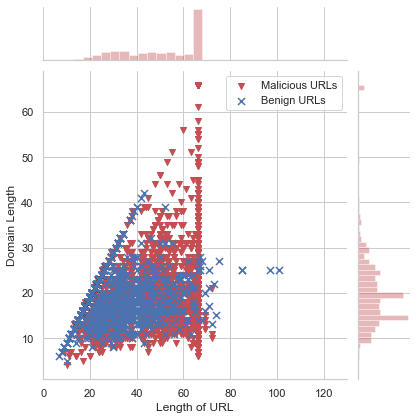

In [16]:
graph = sns.jointplot(x='len of url',y='domain len',color='r',data=df[df['Label']==1 ],marker='v',label='Malicious URLs',xlim=(0,130))

graph.x = df[df['Label']==0 ]['len of url']
graph.y = df[df['Label']==0 ]['domain len']
graph.plot_joint(plt.scatter,marker='x',c='b',s=50,label='Benign URLs')

plt.xlabel('Length of URL')
plt.ylabel('Domain Length')

sns.set(style="whitegrid")
plt.legend(loc='upper right')
plt.rcParams['figure.figsize'] = [15, 5]

plt.show()

Benign URLs overall tend to have both shorter domain names and URLs than malicious URLs (clustered in the lower left).

Next, let's take a look at the age of a domain name measured by how long ago it was registered, measured in months.

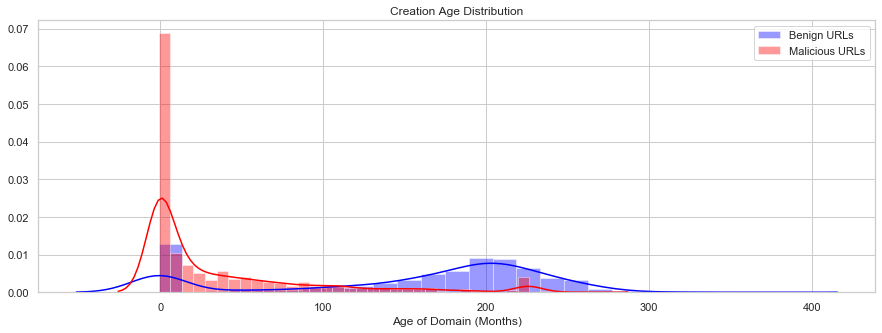

In [17]:
age_domain_benign    = df[df['Label']==0]['create_age(months)']
age_domain_malicious = df[df['Label']==1]['create_age(months)']

sns.distplot(age_domain_benign, color='blue', label='Benign URLs')
sns.distplot(age_domain_malicious, color='red', label='Malicious URLs')

plt.title('Creation Age Distribution')
plt.xlabel('Age of Domain (Months)')

sns.set(style="whitegrid")
plt.legend(loc='upper right')
plt.rcParams['figure.figsize'] = [15, 5]

plt.show()

Benign domain names tend to be older (registered longer ago) than malicious domain names. While a benign domain name is on average almost 15 years old, a malicious domain is often brand new!

## Model Building
Let's build simple models to classify URLs as phishing attempts!

### Feature Selection

<a id="featselect"></a>


First, we'll select the features we think can help determine whether a URL is benign or malicious.

- We saw that benign URLs overall tend to have both shorter domain names and URLs than malicious URLs. Because of this, we'll select **len of url** and **domain len** as a feature.


- We saw that malicious URLs tend to have more dots in them compared to benign URLs. Because of this, we'll select **no of dots** as a feature.


- We saw that benign domain names tend to be older than malicious domain names, which are often brand new. Because of this, we'll select **create\_age(months)** as a feature.


In [18]:
features = ['len of url', 'no of dots', 'domain len', 'create_age(months)']      

X = df[features]
y = df['Label']

## Model 1: Decision Tree

<a id="dectree"></a>

You can think of a decision tree as a series of questions asked about an entity of interest to determine what its classification is. For instance, if we want to classify types of pets, we might begin by asking whether the animal has fur. If it does have fur, we might next want to know the animal's weight or tail length. Eventually, we arrive at a conclusion (or *classification*), such as *it's a dog*! 


### Testing and Training

<a id="testtrain"></a>

There are lots of ways to arrive at a classfication (e.g. *this pet is a dog*). We will build our tree by taking a large subset of the data (for instance, 90 out of 100 pets we know about) and using it as a _training set_. We will save the remaining data we know about (for instance, the remaining 10 out of 100 pets) as a _test set_. We will then give our machine the _training set_ and let it consider different decision tree options (or sets of questions). 

- Note that decision tree algorithms can use different types of decision-making criteria to determine how to best split information for classification. To learn more about how decisions are made in this instance, you can read about the *gini split algorithm*. 

Once we have a tree built from our *training set*, we'll take the _test set_ of data and use our tree (set of questions) to try to predict classifications. Here, we'll ask a lot of questions about each _test set_ URL and try to correctly predict which ones are real and which are phishing.



In [19]:
import sklearn
import sklearn.tree
from sklearn.model_selection import train_test_split

#set a random seed for reproducibility 
from numpy.random import seed
seed(1)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Create a decision tree classifier model using scikit-learn
classifier = sklearn.tree.DecisionTreeClassifier()

# Train the decision tree classifier
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [20]:
# Use the trained classifier to make predictions on the test data
y_pred = classifier.predict(X_test)

# Print the accuracy (percentage of phishing websites correctly predicted)
accuracy = 100.0 * sklearn.metrics.accuracy_score(y_test, y_pred)
print("The accuracy of your decision tree on testing data is: " + str(accuracy))

The accuracy of your decision tree on testing data is: 93.66666666666667


That's pretty good! But it can be hard to understand what's going on under the hood. We can visualize the decision tree as a flow chart. To classify a record as benign or malicious, the algorithm starts at the top of the tree and proceeds left or right asking a question about the data at each node. Our tree starts by asking if the number of dots in the URL is less than or equal to 3.5. If it is, then we move left, if it isn't then we move right. We continue this process until we get to a leaf of the tree, or a node that doesn't have any paths left or right. The output of the algorithm is the class given to that node.

### Visualizing the Decision Tree

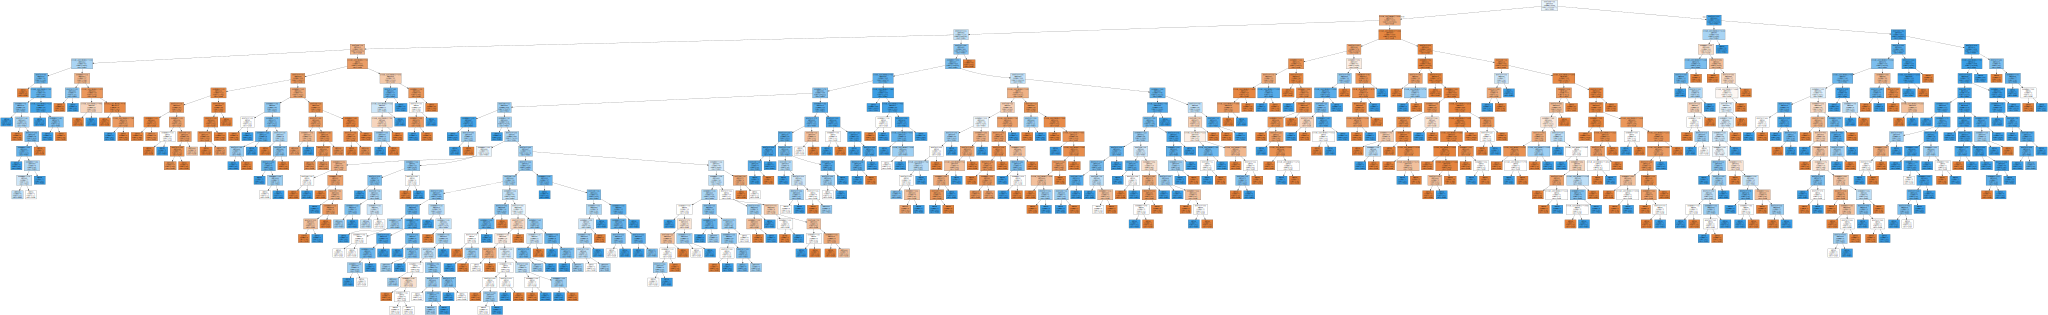

In [21]:
graphviz.Source(sklearn.tree.export_graphviz(classifier,
                                             feature_names=features,
                                             class_names=['Legit', 'Phish'],
                                             out_file=None,
                                             filled = True))

## Visualizing Decision Tree Performance with a Confusion Matrix

<a id="confmat_dectree"></a>

Now let's use a *Confusion Matrix* to visualize how our classifier is doing at classifying our *test set*. 

A confusion matrix is a table that visualizes the performance of a classification algorithm. Each row corresponds to the true class label, here either legit or phish, while each column corresponds to the predicted class. The entry in each cell tells us the number of records of an actual class that were predicted as a given class. The table makes it easy to see how the algorithm is making mistakes. If it was perfect then we'd see zeros everywhere except on the diagonal (the predicted class was always the actual class).


In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[275  22]
 [ 16 287]]


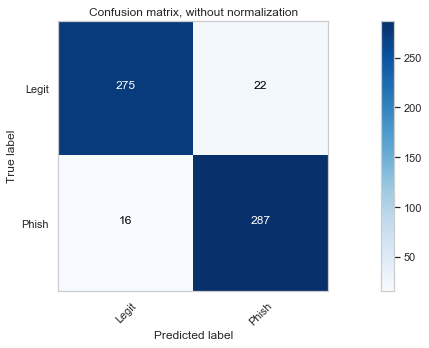

In [23]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ax=plot_confusion_matrix(cnf_matrix, classes=['Legit','Phish'],
                      title='Confusion matrix, without normalization')

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values


plt.show()


This table tells us that of the 275 + 22 = 297 legitimate URLs, 275 were correctly classified as legitimate and 22 were incorrectly classified as phishes. 

False positive rate: 22/297 = 7.4%.

-------

We also see that of the 16 + 287 = 303 phishing URLs, 287 were correctly classified as phishes and 16 were incorrectly classified as legitimate. 

False negative rate: 16/303 = 5.2%.

-------

Later, we will want to compare this model to another model, which will be much easier if we consider normalized percentages in our confusion matrix rather than raw numbers. Thus, we will now make a normalized confusion matrix:

Normalized confusion matrix
[[0.93 0.07]
 [0.05 0.95]]


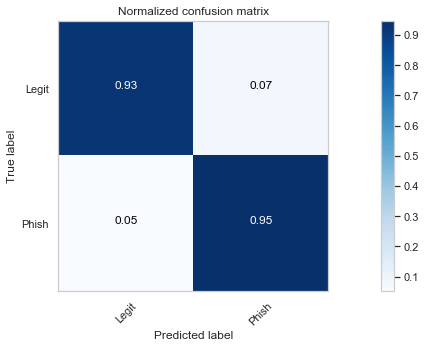

In [24]:
# Plot normalized confusion matrix
plt.figure()
ax=plot_confusion_matrix(cnf_matrix, classes=['Legit','Phish'], normalize=True,
                      title='Normalized confusion matrix')


# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values


plt.show()

<a id="eval_metrics"></a>

**Precision** is defined as the number of true positives over the number of true positives plus the number of false positives. 

**Recall** is defined as the number of true positives over the number of true positives plus the number of false negatives.

**F1 Score** is a weighted average of the precision and recall, defined by:

    2 x (precision x recall) / (precision + recall)

In [25]:
TP = cnf_matrix[0,0]
FP = cnf_matrix[0,1]
FN = cnf_matrix[1,0]
TN = cnf_matrix[1,1]

precision = TP / (TP + FP)
recall = TP / (TP + FN)

print("Decision Tree Precision: " + str(precision))
print("Decision Tree Recall: " + str(recall))

F1 = 2 * (precision * recall) / (precision + recall)

print("Decision Tree F1 Score: " + str(F1))

Decision Tree Precision: 0.9259259259259259
Decision Tree Recall: 0.9450171821305842
Decision Tree F1 Score: 0.935374149659864


Let's take a look at the URLs themselves to see if we can discover anything about why we missed them and see if we can come up with new features to add to the model in order to change our performance (lower the false positive rate, or the false negative rate, or both!)

In [26]:
# Get the row numbers of all the URLs that weren't predicted correctly, and put them in a new Dataframe
misclassified = np.where(y_test != y_pred)
df_misclassified = df.loc[misclassified]

# Print out the benign URLs that were labeled Malicious
print('Benign URLs that were missed by our model:')
print( df_misclassified[df_misclassified['Label'] == 0]['URL'] )

Benign URLs that were missed by our model:
20                            http://www.xbridge.com/
23                     http://www.picture-disc.co.uk/
27                         http://www.puddinhill.com/
47                     http://www.mathisfunforum.com/
109                          http://www.portwine.com/
135                          http://betsyvintage.com/
186                      http://www.theatrenet.co.uk/
199                          http://www.coolbrew.com/
292                  http://www.valentineperfume.com/
355                       http://www.sunrisesoap.com/
443    http://www.espnfc.com/club/liverpool/364/index
450                      http://www.darshanarora.com/
481                   http://www.sceniccellars.co.nz/
554                     http://www.hotelchocolat.com/
596                       http://www.theteahouse.com/
Name: URL, dtype: object


In [27]:
# Print out the malicious URLs that were labeled benign
print('Malicious URLs that were missed by our model:')
print( df_misclassified[df_misclassified['Label'] == 1]['URL'] )

Malicious URLs that were missed by our model:
1      http://taylortea.com/wp-content/plugins/akisme...
16                      http://hymesh.net/listfinancial/
116                      http://handasapc.com/htd12.html
156    http://www.plantaoservopa.com.br/lavisa/paypal...
157    http://cfandfibroliving.com/wp-content/plugins...
179    http://higginsinsulation.com.au/downloader/Mag...
243                   http://rafagroup.es/9713tdij464dda
268    http://mediaexpertsshop.co.uk/wp-content/soft/...
289    http://modernvilla-marbella.com/.z/Excel/other...
322    http://fb-safety-page.at.ua/safety_page_accoun...
326              http://tabtimeline.com/KiTink_1/car.php
328    http://open-pages-fb.at.ua/confirm-accounts.ht...
366    http://elektro-amper.pl/images/css/195b72f0348...
370    http://absolutefootclinic.com.au/usaa.com-inet...
408                      http://stillchildren.me/isc007/
437    http://secure.square.login-stey.usa.cc/account...
447         http://gotmilkpharmacy-cc.com/

Of course, decision trees aren't the only choice for a machine learning algorithm. They are easy to visualize and conceptually understand, but more complicated models exist too. For instance, random forests can be used to harness the predictive power of many decision trees. To see what's available or to learn more, take a look at the scikit-learn documentation. 

## Model 2: Logistic Regression

<a id="logreg"></a>

Another simple model is logistic regression. It's a way of adding up points for each feature (ie. +2 for each dot in a URL) and then translating the total score into a probability that the input is in one class (e.g. phish). We can turn this into a classifier by saying, if the probability is above 50% then we'll call it a *phish*, otherwise it's *legit*.

In [28]:
import sklearn.linear_model

# Create a logisitic regression model using scikit-learn
classifier = sklearn.linear_model.LogisticRegression()

# Train the Logistic regression classifier
classifier.fit(X_train, y_train)

# Use the trained classifier to make predictions on the test data
y_pred = classifier.predict(X_test)

# Print the accuracy (percentage of phishing websites correctly predicted)
accuracy = 100.0 * sklearn.metrics.accuracy_score(y_test, y_pred)
print("The accuracy of your Logistic regression on testing data is: " + str(accuracy))

The accuracy of your Logistic regression on testing data is: 88.16666666666667


It can be a little harder to understand what's going on here, so we can use a different tool, Statsmodels, to study it.

In [29]:
import statsmodels.discrete.discrete_model as sm

logit = sm.Logit(y_train, X_train)
logit.fit().summary()

Optimization terminated successfully.
         Current function value: 0.311280
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Label   No. Observations:                 5399
Model:                          Logit   Df Residuals:                     5395
Method:                           MLE   Df Model:                            3
Date:                Mon, 30 Mar 2020   Pseudo R-squ.:                  0.5495
Time:                        12:09:43   Log-Likelihood:                -1680.6
converged:                       True   LL-Null:                       -3730.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
len of url             0.0596      0.004     14.792      0.000       0.052       0.068
no of dots             0.4318      0.041     10.561      0.000       0.352       0.512
domain len            -0.0912      0.005    -16.840      0.000      -0.102      -0.081
create_age(months)    -0.0160      0.001    -31.569      0.000      -0.017      -0.015
======================================================================================
"""

Here we see that the regression coefficients for each of the features in our model are significant (p-value very low). The coefficients for length of URL and number of dots in URL are both positive, while the coefficients for domain name length and creation age in months are negative. This means that longer URLs with more dots in them are more likely to be phishes (Class = 1), while longer and older domains are more likely to be legit (Class = 0).

## Visualizing Logistic Regression Performance with a Confusion Matrix

<a id="confmat_logreg"></a>

Recall the confusion matrix we used to visualize how our decision tree performed on the _test set_. We will do the same thing here to check how our logistic regression classifier performs.

Confusion matrix, without normalization
[[253  44]
 [ 27 276]]


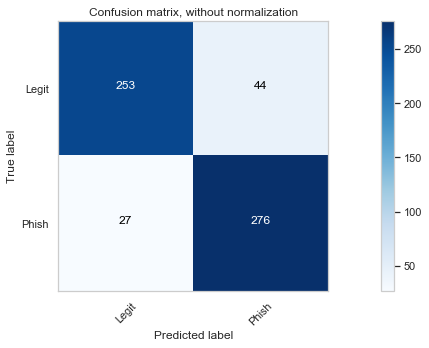

In [30]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ax=plot_confusion_matrix(cnf_matrix, classes=['Legit','Phish'],
                      title='Confusion matrix, without normalization')

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values


plt.show()


This table tells us that of the 253 + 44 = 297 legitimate URLs, 253 were correctly classified as legitimate and 44 were incorrectly classified as phishes. 

False positive rate: 44/297 = 14.8%.

-------

We also see that of the 27 + 276 = 303 phishing URLs, 276 were correctly classified as phishes and 27 were incorrectly classified as legitimate. 

False negative rate: 27/303 = 8.9%.

Normalized confusion matrix
[[0.85 0.15]
 [0.09 0.91]]


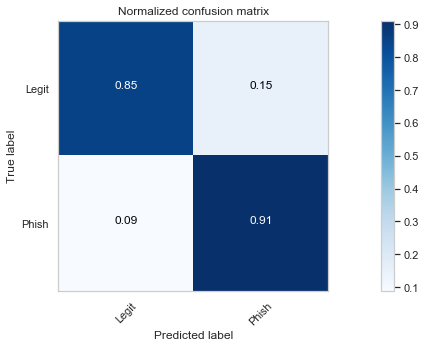

In [31]:
# Plot normalized confusion matrix
plt.figure()
ax=plot_confusion_matrix(cnf_matrix, classes=['Legit','Phish'], normalize=True,
                      title='Normalized confusion matrix')


# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values


plt.show();

<a id="eval_logreg"></a>

In [32]:
TP = cnf_matrix[0,0]
FP = cnf_matrix[0,1]
FN = cnf_matrix[1,0]
TN = cnf_matrix[1,1]

precision = TP / (TP + FP)
recall = TP / (TP + FN)

print("Logistic Regression Precision: " + str(precision))
print("Logistic Regression Recall: " + str(recall))

F1 = 2 * (precision * recall) / (precision + recall)

print("Logistic Regression F1 Score: " + str(F1))

Logistic Regression Precision: 0.8518518518518519
Logistic Regression Recall: 0.9035714285714286
Logistic Regression F1 Score: 0.876949740034662


# Comparing Models: Which is better?

<a id="modcompare"></a>

How we evaluate the two models depends on what metrics we are most concerned with. 

For instance, if we want to be as strict as possible with our security measures, we may care most about the false negative rate (describing the links predicted to be benign when they were actually malicious). If we select our model based on this metric, the decision tree is the better model (5% vs. the logistic regression at 9%).

If we care about filtering out phishing links but want to be very careful not to mislabel real links, we may care most about the false positive rate (describing the links predicted to be malicious when they were actually benign). If we select our model based on this metric, the decision tree is still the better model (7% vs. the logistic regression at 15%).

In this case, both metrics discussed point towards the **decision tree as the better model**. However, in other applications this may not be the case. Keep in mind that metrics should always be evaluated on a case-by-case basis.